In [1]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import random
# from dataset import KaggleDataset
import torchvision.transforms.functional as tx
from model import YOLOv1
from loss import Loss
import cv2
import os
import numpy as np
import math
from datetime import datetime
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from helper import *
from dataset import *
# from loss import *

In [2]:
  
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
few_data = False
data_num = 10
to_gray = False

In [4]:
init_lr = 0.001
base_lr = 0.01
momentum = 0.9
weight_decay = 5.0e-4
num_epochs = 135
batch_size = 64


In [5]:
image_dir = "../data/image"
global_mean = [158.122433332762, 135.86361008407835, 118.4334553918209]
global_std = [58.57134455799642, 58.4258764351661, 59.034157439521465] 
# Path to label files.
train_label = '../data/train.txt'
valid_label = '../data/valid.txt'

In [6]:
train_dataset = MyDataset(True, image_dir, train_label)
train_loader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, sampler = None)
valid_dataset = MyDataset(False, image_dir, valid_label)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(valid_loader))

6
2


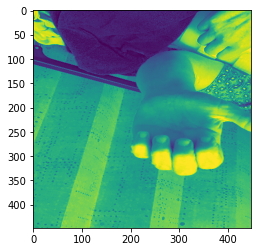

In [7]:
image, target = next(iter(train_loader))

plt.imshow(image[0][0])

In [8]:
def train(train_loader, yolo, optmizer, criterion,epoch):
    yolo.train()
    total_loss = 0
    total_batch = 0
    for i, (imgs, targets) in enumerate(train_loader):

        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()

        preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        total_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         print(loss)
    return total_loss

        

In [9]:
def valid(valid_loader, yolo):
    yolo.eval()
    val_loss = 0.0
    total_batch = 0

    for i, (imgs, targets) in enumerate(valid_loader):

        batch_size_this_iter = imgs.size(0)
        imgs = Variable(imgs)
        targets = Variable(targets)
        imgs, targets = imgs.cuda(), targets.cuda()


        with torch.no_grad():
            preds = yolo(imgs)
        loss = criterion(preds, targets)
        loss_this_iter = loss.item()
        val_loss += loss_this_iter * batch_size_this_iter
        total_batch += batch_size_this_iter
#     val_loss /= float(total_batch)
    return val_loss

In [10]:
model_conv = torchvision.models.resnet101(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
print(model_conv)

model_conv = nn.Sequential(*(list(model_conv.children())[:-2]))
yolo = YOLOv1(model_conv, num_classes=1)
print(yolo)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

YOLOv1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

In [14]:
criterion = Loss(feature_size=yolo.feature_size)
origin_lr = 1e-4
optimizer = torch.optim.Adam(yolo.parameters(), lr=origin_lr, weight_decay=weight_decay)

In [15]:
resume_date="12_5_1"
yolo.load_state_dict(torch.load("../data/model/"+resume_date+"/best_MSE_model.pth"))
yolo.to("cuda")
date = "12_24_1"
# date="test"
writer = SummaryWriter("runs/"+date)
min_loss = 10000
not_improve = 0
lr = origin_lr
save_frequency = 0
if not os.path.exists("../data/model"):
    os.mkdir("../data/model")
if not os.path.exists("../data/model/"+date):
    os.mkdir("../data/model/"+date)
min_MSE = 10000
for i in range(5000):
    print("epoch : ",i)
#     update_lr(optimizer, epoch, float(i) / float(len(train_loader) - 1))
#     lr = get_lr(optimizer)
    
    train_loss = train(train_loader, yolo, optimizer, criterion,i)
    valid_loss = valid(valid_loader, yolo)
    save_frequency+=1
    if save_frequency >= 1 :
        train_precision_score = train_score(yolo)
        valid_precision_score = valid_score(yolo)
        print("train MSE : ",train_precision_score)
        print("valid MSE : ",valid_precision_score)
        writer.add_scalar("MSE/train", train_precision_score, i)
        writer.add_scalar("MSE/valid", valid_precision_score, i)
        if min_MSE > valid_precision_score:
            min_MSE = valid_precision_score
            not_improve = 0
            torch.save(yolo.state_dict(), "../data/model/"+date+"/best_MSE_model.pth")
            print("@@@@@@@@@@@@@save best MSE model@@@@@@@@@@@@@@@@@@@")
        save_frequency = 0
    print("train loss :",train_loss/(len(train_loader)*batch_size))
    print("valid loss :",valid_loss/(len(valid_loader)*batch_size))
    writer.add_scalar("Loss/train", train_loss/(len(train_loader)*batch_size), i)
    writer.add_scalar("Loss/valid", valid_loss/(len(valid_loader)*batch_size), i)
    writer.add_scalar("learning rate", lr, i)
    if min_loss>valid_loss/(len(valid_loader)*batch_size):
        min_loss = valid_loss/(len(valid_loader)*batch_size)
        not_improve = 0
        torch.save(yolo.state_dict(), "../data/model/"+date+"/best_Loss_model.pth")
        print("@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@")
    else:
        not_improve+=1
        if not_improve==60:
            print("############reduce lr#############")
            not_improve = 0
            lr/=2
            for g in optimizer.param_groups:
                g['lr'] = lr
    torch.save(yolo.state_dict(), "../data/model/"+date+"/last_model.pth")
#     break

epoch :  0
train MSE :  0.1888147201176226
valid MSE :  0.4899800754348069
@@@@@@@@@@@@@save best MSE model@@@@@@@@@@@@@@@@@@@
train loss : 0.9031830035770932
valid loss : 1.0268951086327434
@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@
epoch :  1
train MSE :  0.1886365814377692
valid MSE :  0.35973720783381213
@@@@@@@@@@@@@save best MSE model@@@@@@@@@@@@@@@@@@@
train loss : 0.7936906764904658
valid loss : 0.9038239773362875
@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@
epoch :  2
train MSE :  0.1846316177443885
valid MSE :  0.3688209819956983
train loss : 0.7731135349410275
valid loss : 0.912378191947937
epoch :  3
train MSE :  0.18891570341789674
valid MSE :  0.37723834738833883
train loss : 0.7530469944079717
valid loss : 0.8960773358121514
@@@@@@@@@@@@@save best Loss model@@@@@@@@@@@@@@@@@@@
epoch :  4
train MSE :  0.1840112080553722
valid MSE :  0.3687641804587533
train loss : 0.756296360399574
valid loss : 0.8678753981366754
@@@@@@@@@@@@@save best Loss model@@@@@@@@

KeyboardInterrupt: 

In [ ]:
!nvidia-smi
